In [52]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# First, we import the four csv files that we are going to use
df1 = pd.read_csv("./data/caracteristics.csv", encoding='latin-1')
df2 = pd.read_csv("./data/places.csv")
df3 = pd.read_csv("./data/users.csv")
df4 = pd.read_csv("./data/vehicles.csv")

# Then, we merge all the dataframes together using the column 'Num_Acc' that they have in common
df1 = pd.merge(df1, df2, how="outer", on="Num_Acc")
df2 = pd.merge(df3, df4, how='outer', on="Num_Acc")

data = pd.merge(df1, df2, how='outer', on="Num_Acc")

In [53]:
# Here, we select the columns that we want to keep and we rename it appropriately
columns = ['an', 'mois', 'grav', 'lat', 'long']

data = data[columns]
data.columns = ['Year', 'Month', 'Severity', 'Latitude', 'Longitude']

data.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)

data['Severity'].replace({2: 4, 4: 2}, inplace=True)

severity_description = {
    1: "Unscathed",
    2: "Light injury",
    3: "Hospitalized wounded",
    4: "Killed"
}

data

,Year,Month,Severity,Latitude,Longitude
0,16,2,1,0.0,0.0
1,16,2,1,0.0,0.0
2,16,2,3,0.0,0.0
3,16,2,3,0.0,0.0
4,16,3,3,0.0,0.0
...,...,...,...,...,...
3552260,5,12,1,0.0,0.0
3552261,5,12,3,0.0,0.0
3552262,5,12,3,0.0,0.0
3552263,5,12,3,0.0,0.0


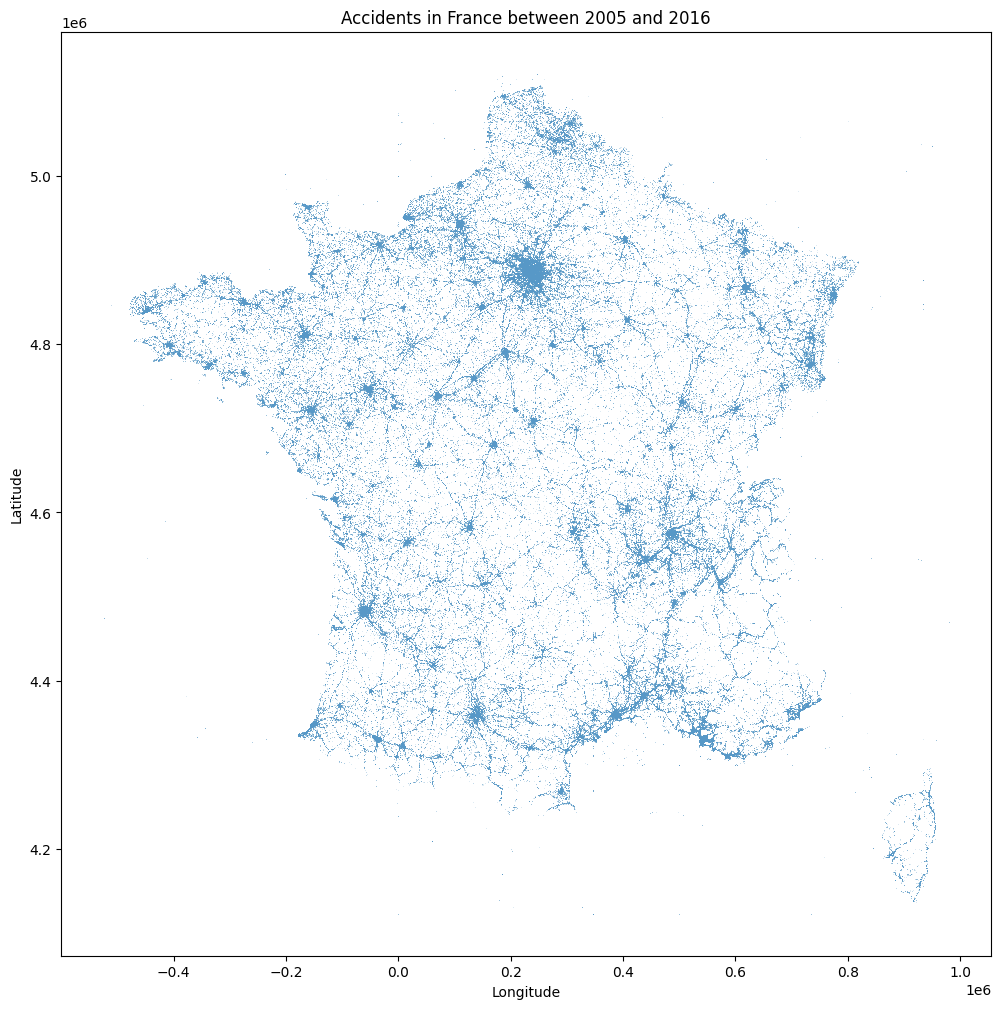

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data processing
data['Longitude'] = data['Longitude'].replace('-', 0).astype('double')
data['Latitude'] = data['Latitude'].replace('-', 0).astype('double')

# Data filtering
data = data.loc[(data['Longitude'] < 3*10**6) & (data['Latitude'] > 3*10**6) & (data['Latitude'] < 5.2*10**6)]

# Scatterplot creation
plt.figure(figsize=(12, 12))
sns.scatterplot(data=data, x='Longitude', y='Latitude', s=0.1)
plt.title("Accidents in France between 2005 and 2016")
plt.show()

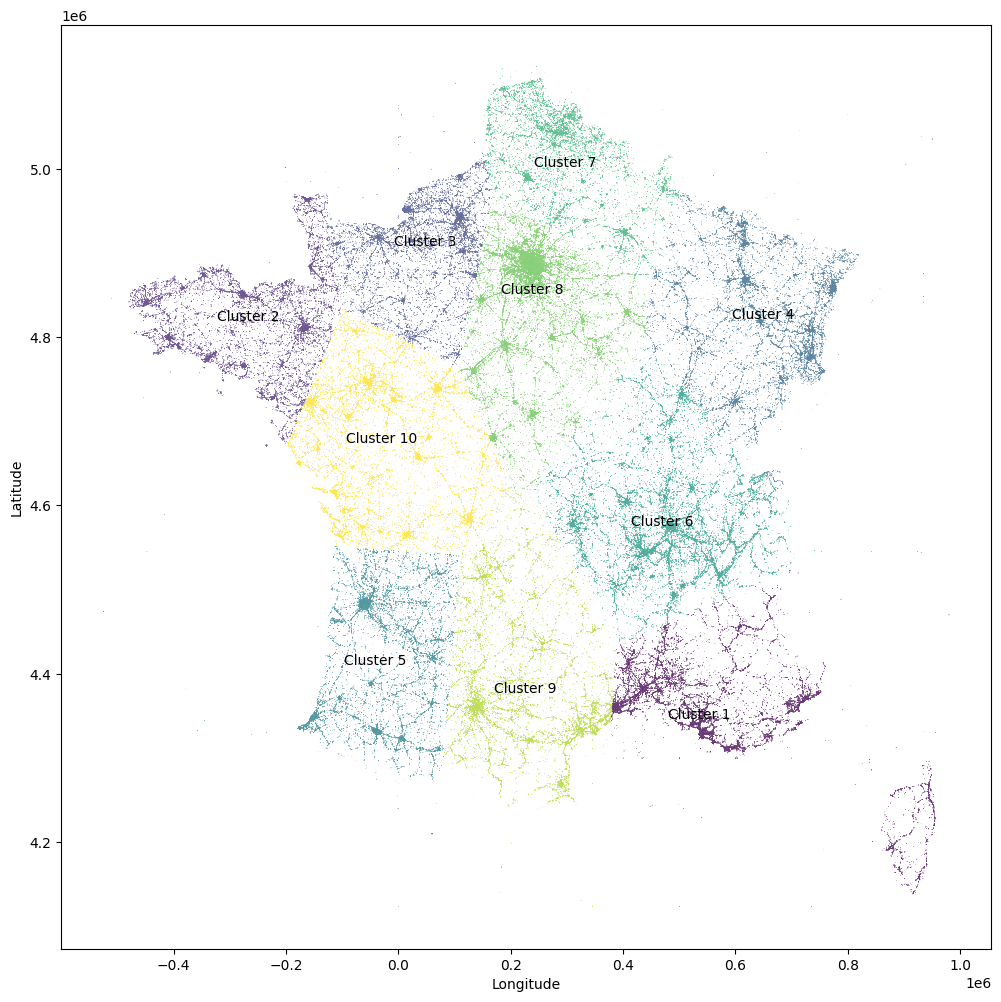

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(data[['Longitude', 'Latitude']])

centers = kmeans.cluster_centers_
labels = kmeans.labels_
cluster_name = ["Cluster "+str(i + 1) for i in set(labels)]

plt.figure(figsize=(12,12))
sns.scatterplot(data=data, x="Longitude", y="Latitude", c=labels, s=0.1)
for i, txt in enumerate(cluster_name):
    plt.text(centers[i,0], centers[i,1], s=txt, ha="center", va="center", color='black')

plt.show()

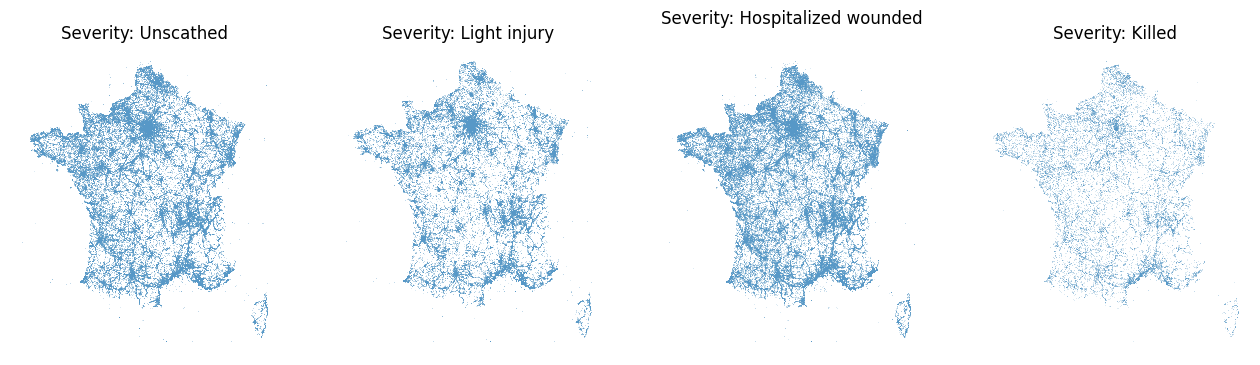

In [56]:
plt.figure(figsize=(16,4))

for i in range(1, 5):
    plt.subplot(1, 4, i)
    sns.scatterplot(data=data.loc[data['Severity']==i], x='Longitude', y='Latitude', s=0.1)
    plt.axis(False)
    plt.title(f"Severity: {severity_description[i]}")
plt.show()

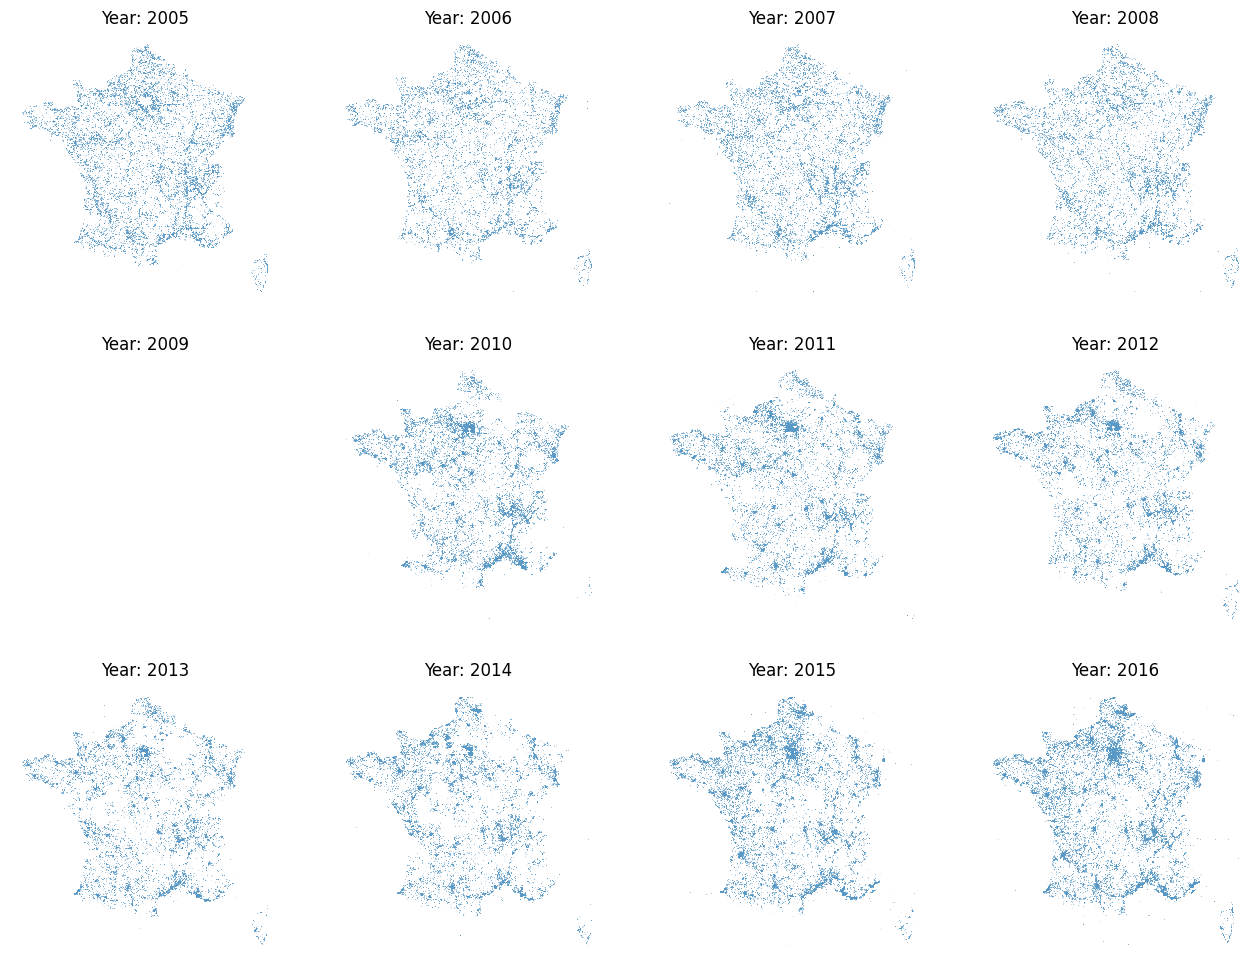

In [57]:
plt.figure(figsize=(16,12))

for i in range(1, 13):
    plt.subplot(3, 4, i)
    sns.scatterplot(data=data.loc[data['Year']==4+i], x='Longitude', y='Latitude', s=0.1)
    plt.axis(False)
    plt.title(f"Year: {2004 + i}")
plt.show()